<h3>Random Forest Classifier - Respondent 1 </h3>

<h2>Pre-processing</h2>

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the CSV file
file_path = '001-b45731a0_emotions_with_cognitive_tesk_and_screen.csv'
data = pd.read_csv(file_path)

# Load the second CSV file
new_file_path = '003-91dc3428_emotions_with_cognitive_tesk_and_screen.csv'
new_data = pd.read_csv(new_file_path)

# Merge the two dataframes
data = pd.concat([data, new_data])

# Drop the Timestamp column
data = data.drop('Timestamp', axis=1)

# Drop rows with NaN values in the target column
data = data.dropna(subset=['Cognitive Task'])
print(data.head())

# Identify numeric and categorical features, excluding the target variable
all_columns = data.columns.tolist()
target_column = 'Cognitive Task'
all_columns.remove(target_column)
numeric_features = data[all_columns].select_dtypes(include=['int64', 'float64']).columns
categorical_features = data[all_columns].select_dtypes(include=['object']).columns


# Exclude the target column from the numeric features
numeric_features = numeric_features.drop('Cognitive Task', errors='ignore')

# Define the preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the preprocessing steps into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
y = data['Cognitive Task']
X = data.drop('Cognitive Task', axis=1)
X_preprocessed = preprocessor.fit_transform(X)

# Get the transformed feature names for the categorical columns
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine the numeric and transformed categorical feature names
all_feature_names = list(numeric_features) + list(cat_feature_names)

# Convert the preprocessed data back to a DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# Reset the index of y
y.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


         Anger  Contempt   Disgust      Fear       Joy   Sadness  Surprise  \
3705  0.125566  0.136948  0.021518  0.116770  0.041248  0.112264  0.059114   
3706  0.125566  0.137617  0.021531  0.132963  0.040812  0.112249  0.067522   
3707  0.125566  0.137096  0.021582  0.169795  0.040925  0.111568  0.087434   
3708  0.125566  0.136868  0.021714  0.218535  0.041063  0.111219  0.114075   
3709  0.125566  0.137239  0.021806  0.256706  0.040785  0.110944  0.135015   

      Engagement  Valence  Sentimentality  Confusion Cognitive Task Screens  
3705    0.328766      0.0        0.976782   0.036977        Explore     Map  
3706    0.328766      0.0        0.911952   0.034095        Explore     Map  
3707    0.328766      0.0        0.831274   0.026797        Explore     Map  
3708    0.328766      0.0        0.829263   0.019318        Explore     Map  
3709    0.328766      0.0        0.773583   0.014509        Explore     Map  


<h2>Random Forest Classifier</h2>

Confusion Matrix:
 [[7230   28   32   19   14   83   82]
 [ 145 2743   34    2    7   64   62]
 [ 128   16 5038    4   13   23   88]
 [   7    0   11 1821    0    0  212]
 [ 141   15   26    5 1841   53   36]
 [ 267   36   27    0   14 4238    0]
 [  18    2    5   46    4    0 5072]]

Classification Report:
                      precision    recall  f1-score   support

     Assess Results       0.91      0.97      0.94      7488
           Conclude       0.97      0.90      0.93      3057
            Explore       0.97      0.95      0.96      5310
              Focus       0.96      0.89      0.92      2051
Generate Hypothesis       0.97      0.87      0.92      2117
           Set Goal       0.95      0.92      0.94      4582
    Test Hypothesis       0.91      0.99      0.95      5147

           accuracy                           0.94     29752
          macro avg       0.95      0.93      0.94     29752
       weighted avg       0.94      0.94      0.94     29752


Accuracy Score

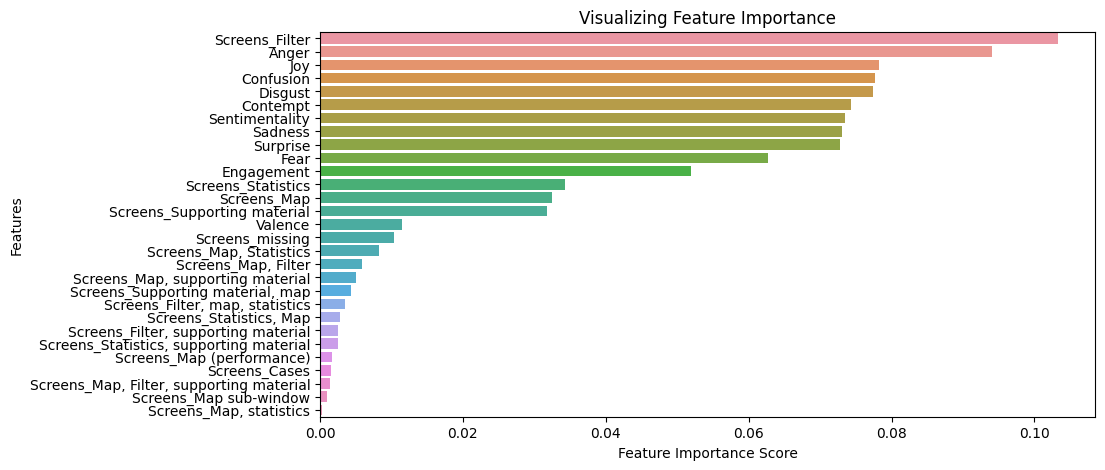

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Plot the feature importance
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Feature Importance')
plt.show()


<h3> With Recursive Feature Elimination (RFE) </h3>

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select the top k features
k = 5  # Number of features to select
rfe = RFE(estimator=model, n_features_to_select=k, step=1)
rfe.fit(X_train, y_train)

# Transform the train and test datasets using the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the model on the transformed training data
model.fit(X_train_rfe, y_train)

# Test the model
y_pred = model.predict(X_test_rfe)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))



TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'missing_values'

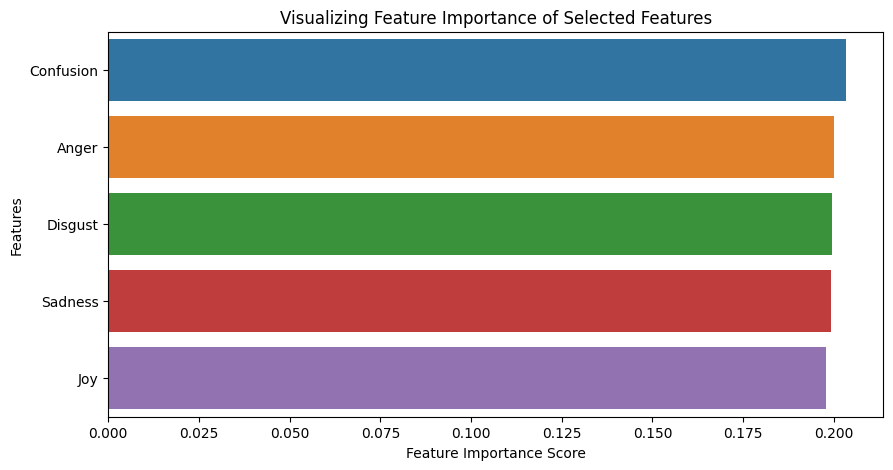

In [14]:
# Define all_feature_names based on the column names of your DataFrame
all_feature_names = X_train.columns

# Plot the feature importance of the selected features
importances = model.feature_importances_
selected_feature_indices = np.where(rfe.support_)[0]
selected_feature_names = all_feature_names[selected_feature_indices]
feature_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Feature Importance of Selected Features')
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score

# Use 5-fold cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_preprocessed, y, cv=5)
print("Average cross-validation score:", np.mean(cv_scores))


Average cross-validation score: 0.4517843080538805


<h2>Perform Prediction on Respondent 2</h2>

In [29]:
import pandas as pd

# Set the low_memory parameter to False
df = pd.read_csv('002_a2da21a1-data-for-prediction.csv', low_memory=False)


# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Fill missing values in numeric columns with the mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print(df.shape[0])

df_selected = df.loc[:, selected_feature_names]

# Reset the index of y
y.reset_index(drop=True, inplace=True)

predictions = model.predict(df_selected)

df['predictions'] = predictions
df.to_csv('resp_2_predictions.csv', index=False)



36089


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
